
# <span style="color:DarkSeaGreen">JumpStart Lab 1</span>

This lab does the following:

- Provision a model via Jumpstart
- Create a JumpStart endpoint
- Interacts with the model



# <span style="color:DarkSeaGreen">Prepare Your Environment</span>
### Requirements for this Jupyter Notebook Lab if running in VSCode or equivalent local IDE
##### Note these are macOS specific
- Credentials
  - You need credentials to your AWS account to execute this Jupyter Lab if running locally from your laptop
    - Locally: Credentials and therefore permissions asscociated with the IAM user (with CLI access enabled) are provided by AWS configure connection to your AWS account
    - Cloud: Permissions provided via logged in user
- Installers:
  - Pip
    - Python libraries
    - Works inside Python envs
  - homebrew (brew) (mac)
    - System software, tools, and dependencies
    - Works at OS level

- Run the commands of the cell below in a terminal window to create a virtual environment if you need one
  - Note check your Python version first, then if ok, copy the rest and run in terminal window
  - Note if you copy and paste the multiple lines and run as one you will get zsh: command not found: # errors because of the comments, but you can ignore
  - Remember to restart the kernel to pick up the new venv
  - The venv can be deleted via the last cell in this notebook iof no longer needed
- If you already have a virtual environment, then just activate it as shown in the second cell below
  - Venv (can be created below) used by this notebook is *venv-jumpstart-lab1*

In [ ]:
# Check your credentials (AWS identity) to confirm you are using the right credentials, can also run in a terminal window (remove the !)
!aws sts get-caller-identity

In [ ]:
### STOP ###
### IF USING THIS NOTEBOOK IN A SAGEMAKER JUPYTER NOTEBOOK INSTANCE, THEN SKIP TO THE NEXT CELL ###
### OTHERWISE, IF USING VSCODE OR EQUIVALENT LOCAL IDE, THEN CONTINUE BELOW ###
### This script is for setting up your environment for the JumpStart Lab 1 ###
# do you need to upgrade python first? Your available version of Python is used to create the virtual environment
python3 --version

### STOP ###
### DO YOU NEED TO UPGRADE PYTHON ###
# upgrade to the latest version of python if required
brew install python
# restart vscode to pickup new version of python
python3 --version

### STOP ###
### OK IF YOU HAVE THE CORRECT VERSION OF PYTHON, CONTINUE ###
# create a virtual environment
python3 -m venv venv-jumpstart-lab1
# activate the virtual environment
source venv-jumpstart-lab1/bin/activate
### COPY TO HERE ONLY IF RUNNING AS ONE COPY AND PASTE ###

### STOP ###
### MAKE SURE ABOVE VENV GETS ACTIVATED BEFORE RUNNING THE REST ###
# upgrade pip
pip install --upgrade pip
# jupyter kernel support
pip install ipykernel
# add the virtual environment to jupyter
python  -m ipykernel install --user --name=venv-jumpstart-lab1 --display-name "Python (venv-jumpstart-lab1)"
# install the required packages - may need to specify the path here if not in the correct folder in terminal window
pip install -r requirements_lab1.txt
# pip install -r Documents/github/labs-sagemaker/jumpstart/requirements_lab1.txt
# verify the installation
pip list

### RESTART VSCODE TO PICKUP THE NEW VENV ###

In [ ]:
### STOP ###
### This command is for activating an environment that already exists, its for use in a terminal window if you need it ###
source venv-jumpstart-lab1/bin/activate
pip list

# use pip freeze if you prefer for requirements.txt freiendly format
### ALSO MAKE SURE YOU SELECT IT AS YOUR KERNEL FOR THIS JUPYTER NOTEBOOK ###

In [ ]:
### STOP ###
### IF USING THIS NOTEBOOK IN A SAGEMAKER JUPYTER NOTEBOOK INSTANCE, THEN EXECUTE THIS CELL ###
!pip install --upgrade pip
!pip install --upgrade sagemaker
!pip install --upgrade locust

# Lab 1 Starts Here!

# <span style="color:DarkSeaGreen">Setup</span>

In [10]:
# region
# for the purpose of this lab, us-east-1, us-west-2, eu-west-1 has the broadest coverage of JumpStart models and instance types
# if you provision in other regions, you may not have access to all the models or instance types, and may need to request increase of quotas for endpoint usage for some instance types
myRegion='us-east-1'

# iam
myRoleSageMakerExecution="doit-jumpstart-sagemaker-execution-role"
myRoleSageMakerExecutionARN='RETRIEVED FROM ROLE BELOW'

# parameter store
myParameterStoreChosenModel='doit-jumpstart-sagemaker-chosen-model'
myParameterStoreEndpointName='doit-jumpstart-sagemaker-endpoint-name'
myParameterStoreIAMARN='doit-jumpstart-sagemaker-iam-arn'

print ('Done! Move to the next cell ->')

Done! Move to the next cell ->


In [11]:
import json
import boto3
from certifi import where

botoSession = boto3.Session(region_name=myRegion)

# Configure boto3 to use certifi's certificates - helps avoid SSL errors if your system’s certificate store is out of date or missing root certs
sts_client = boto3.client('sts', verify=where())
myAccountNumber = sts_client.get_caller_identity()["Account"]
print(myAccountNumber)
print(sts_client.get_caller_identity()["Arn"])

# create clients we can use later
# iam
iam = boto3.client('iam', region_name=myRegion, verify=where())
# ssm
ssm = boto3.client('ssm', region_name=myRegion, verify=where())

print ('Done! Move to the next cell ->')

546709318047
arn:aws:iam::546709318047:user/simon-davies-cli
Done! Move to the next cell ->


In [12]:
# define tags added to all services we create
myTags = [
    {"Key": "env", "Value": "non_prod"},
    {"Key": "owner", "Value": "doit-jumpstart"},
    {"Key": "project", "Value": "lab1"},
    {"Key": "author", "Value": "simon"},
]
myTagsDct = {
    "env": "non_prod",
    "owner": "doit-jumpstart",
    "project": "lab1",
    "author": "simon",
}

print ('Done! Move to the next cell ->')

Done! Move to the next cell ->


# <span style="color:DarkSeaGreen">IAM</span>

In [49]:
def getSageMakerExecutionRole():
    """
    Creates a role required for SageMaker to run jobs on your behalf
    Only needed if this is being run in a local IDE, not needed if in SageMaker Studio or SageMaker Notebook Instance

    Args:
        None

    Returns:
        An IAM execution role ARN
    """

    # trust policy for the role
    roleTrust = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow",
                "Principal": {
                    "Service": "sagemaker.amazonaws.com"
                },
                "Action": "sts:AssumeRole"
            }
        ]
    }

    # check if the role exists
    try:
        role = iam.get_role(RoleName=myRoleSageMakerExecution)
        print("Role already exists. Using the existing role.")
        return role['Role']['Arn']
    except iam.exceptions.NoSuchEntityException:
        print("Role does not exist. Creating a new role.")
        
    # create execution role for sagemaker - allows SageMaker notebook instances, training jobs, and models to access S3, ECR, and CloudWatch on your behalf
    # this role is only created if we are running this notebook in a local ide, if we are in a jupyterlab in sagemaker studio, we dont need it as already created and available
    role = iam.create_role(
        RoleName=myRoleSageMakerExecution,
        AssumeRolePolicyDocument=json.dumps(roleTrust),
        Description="Service excution role for sagemaker ai use including inside jupyter notebooks",
        Tags=[
            *myTags,
        ],
    )

    # attach managed policy to the role AmazonSageMakerFullAccess
    iam.attach_role_policy(
        RoleName=myRoleSageMakerExecution,
        PolicyArn="arn:aws:iam::aws:policy/AmazonSageMakerFullAccess"
    )

    # store the role arn in parameter store for use in other notebooks
    ssm.put_parameter(
        Name=myParameterStoreIAMARN,
        Description='The ARN of the IAM role used by SageMaker for execution of jobs',
        Value=role['Role']['Arn'],
        Type='String',
        Tags=[
            *myTags,
        ],
    )   

    return role['Role']['Arn']

# <span style="color:DarkSeaGreen">Get Execution Role and Session</span>
- SageMaker requires an execution role to assume on your behalf

In [50]:
from sagemaker.session import get_execution_role
from sagemaker.session import Session

try:
    # if this is being run in a SageMaker AI JupyterLab Notebook
    myRoleSageMakerExecutionARN = get_execution_role()
except:
    # if this is being run in a local IDE - we need to create our own role
    myRoleSageMakerExecutionARN = getSageMakerExecutionRole()

# make sure we get a session in the correct region (needed as it can use the aws configure region if running this locally
sageMakerSession = Session(boto_session=botoSession)

print(myRoleSageMakerExecutionARN)
print(sageMakerSession)

print ('Done! Move to the next cell ->')

Couldn't call 'get_role' to get Role ARN from role name simon-davies-cli to get Role path.


Role does not exist. Creating a new role.
arn:aws:iam::546709318047:role/doit-jumpstart-sagemaker-execution-role
Done! Move to the next cell ->


# <span style="color:DarkSeaGreen">Provision a JumpStart Model</span>
- Provision a model via Jumpstart
- If you prefer, you can also do this via the JumpStart console, but you will have to bring in the endpoint that you create to continue with this code
### Example models to provision
- Qwen2.5 Coder 32B Instruct
  - *model_id, model_version = "huggingface-llm-qwen2-5-coder-32b-instruct", "*"*
  - this model requires an instance needs with multiple GPUs
    - a single GPU will fail with an error like "AssertionError: Each process is one gpu"
  - requires a huge instance to run, eg 
    - ml.g6.48xlarge (low-cost inference at scale, not training)
      - **needs an aws quota increase for this instance for endpoint usage**
    - ml.p4de.24xlarge or ml.p5.48xlarge (alternatives maximum raw performance / less headache, go)
      - **needs an aws quota increase for this instance for endpoint usage**
    - ml.g5.48xlarge
      - good for a poc - widely supported, good memory, reasonably costed
      - good for inference of 32B models with tensor parallelism (JumpStart handles this automatically when deploying with multiple GPUs)
      - **needs an aws quota increase for this instance for endpoint usage**
- see https://aws.amazon.com/sagemaker/ai/pricing/ for pricing, **larger instances can be very expensive per hour**
- If you deply the model and you get a quota error, you will need to visit Service Quotas via the console and request an increase
  - go to SageMaker service and search for the instance
  - make sure your quota allows for auto scaling max
- <span style="color:HotPink">ONLY meta-textgeneration-llama-2-7b|ml.g5.4xlarge will be used in Lab 3 due to cost (step scales to 10 instances)</span>
  - If you choose to provision a different model here, Lab 3 will NOT run
- DO NOT LEAVE LARGE INSTANCES RUNNING LONGER THAN YOU NEED TO $$$!


In [51]:
# the model we want to provision - THIS DISPLAYS AN INPUT BOX FOR YOU TO CHOOSE A MODEL
# jump into the console, click on JumpStart, find a model you like and copy the model id from the details page
# https://aws.amazon.com/sagemaker/ai/pricing/
options = [
    "llm|huggingface-llm-qwen2-5-coder-32b-instruct|ml.g5.48xlarge $$$$",
    "llm|huggingface-llm-qwen2-5-coder-32b-instruct|ml.g5.24xlarge $$$",
    "llm|meta-textgeneration-llama-2-7b|ml.g5.4xlarge $$|Allowed for use in Lab 3",
    "txt2img|model-imagegeneration-stabilityai-stable-diffusion-xl-base-1-0|ml.g5.4xlarge $$",
]

print("Select an option:")
for i, opt in enumerate(options, 1):
    print(f"{i}. {opt}")

choice = int(input("Enter the number of the model you want: "))
selected = options[choice - 1]

modelType = selected.split("|")[0]
modelID = selected.split("|")[1]
instanceType = selected.split("|")[2].split(" ")[0]

# store the model in a parameter store for use in other labs
ssm.put_parameter(
    Name=myParameterStoreChosenModel,
    Description='the model chosen in lab1',
    Value=selected,
    Type='String',
    Tags=[
        *myTags,
    ],
)

print(f"You selected: model type {modelType} {modelID} on {instanceType}")
print("Done! Move to the next cell ->")

Select an option:
1. llm|huggingface-llm-qwen2-5-coder-32b-instruct|ml.g5.48xlarge $$$$
2. llm|huggingface-llm-qwen2-5-coder-32b-instruct|ml.g5.24xlarge $$$
3. llm|meta-textgeneration-llama-2-7b|ml.g5.4xlarge $$|Allowed for use in Lab 3
4. txt2img|model-imagegeneration-stabilityai-stable-diffusion-xl-base-1-0|ml.g5.4xlarge $$
You selected: model type txt2img model-imagegeneration-stabilityai-stable-diffusion-xl-base-1-0 on ml.g5.4xlarge
Done! Move to the next cell ->


In [52]:
from sagemaker.jumpstart.model import JumpStartModel
# if your selected model is gated, you will need to set accept_eula to True to accept the model end-user license agreement (EULA)
accept_eula = True

# https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.jumpstart.model.JumpStartModel
model = JumpStartModel(
    model_id=modelID,
    model_version="*",
    instance_type=instanceType,      
    role=myRoleSageMakerExecutionARN,
    sagemaker_session=sageMakerSession,
    region=myRegion
)

# deploy the model to an endpoint
# this will take a while
predictor = model.deploy(accept_eula=accept_eula, initial_instance_count=1)

print ('Done! Move to the next cell ->')

Using model 'model-imagegeneration-stabilityai-stable-diffusion-xl-base-1-0' with wildcard version identifier '*'. You can pin to version '1.0.12' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


-------------!Done! Move to the next cell ->


In [53]:
# store the predictor name in a parameter store for use in other notebooks
ssm.put_parameter(
    Name=myParameterStoreEndpointName,
    Description='the name of the sagemaker endpoint created in lab1',
    Value=predictor.endpoint_name,
    Type='String',
    Tags=[
        *myTags,
    ],
)

print ('Done! Move to the next cell ->')

Done! Move to the next cell ->


In [54]:
# required if an image model is being used
def decode_and_show(model_response) -> None:
    from PIL import Image
    import base64
    import io
    
    image = Image.open(io.BytesIO(base64.b64decode(model_response)))
    display(image)
    image.close()

Using your own as no example models available for this model.


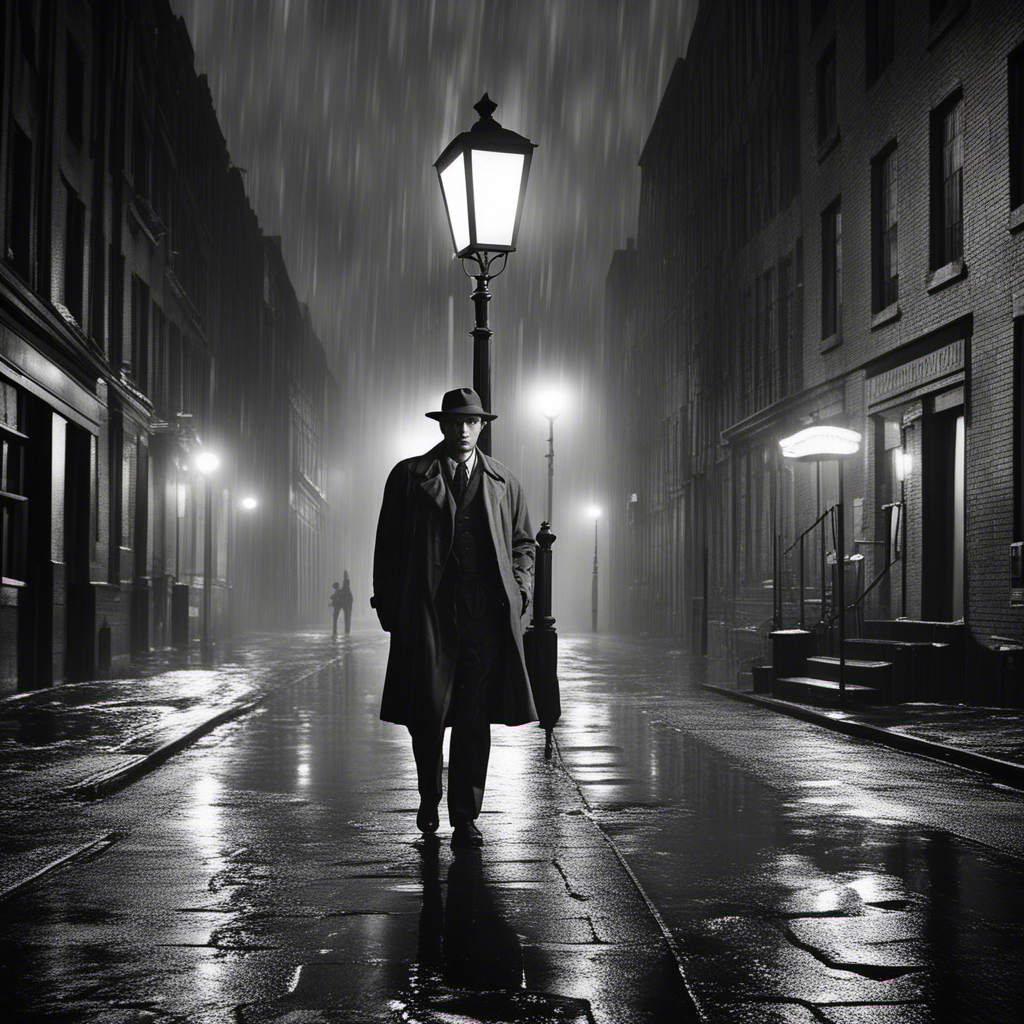

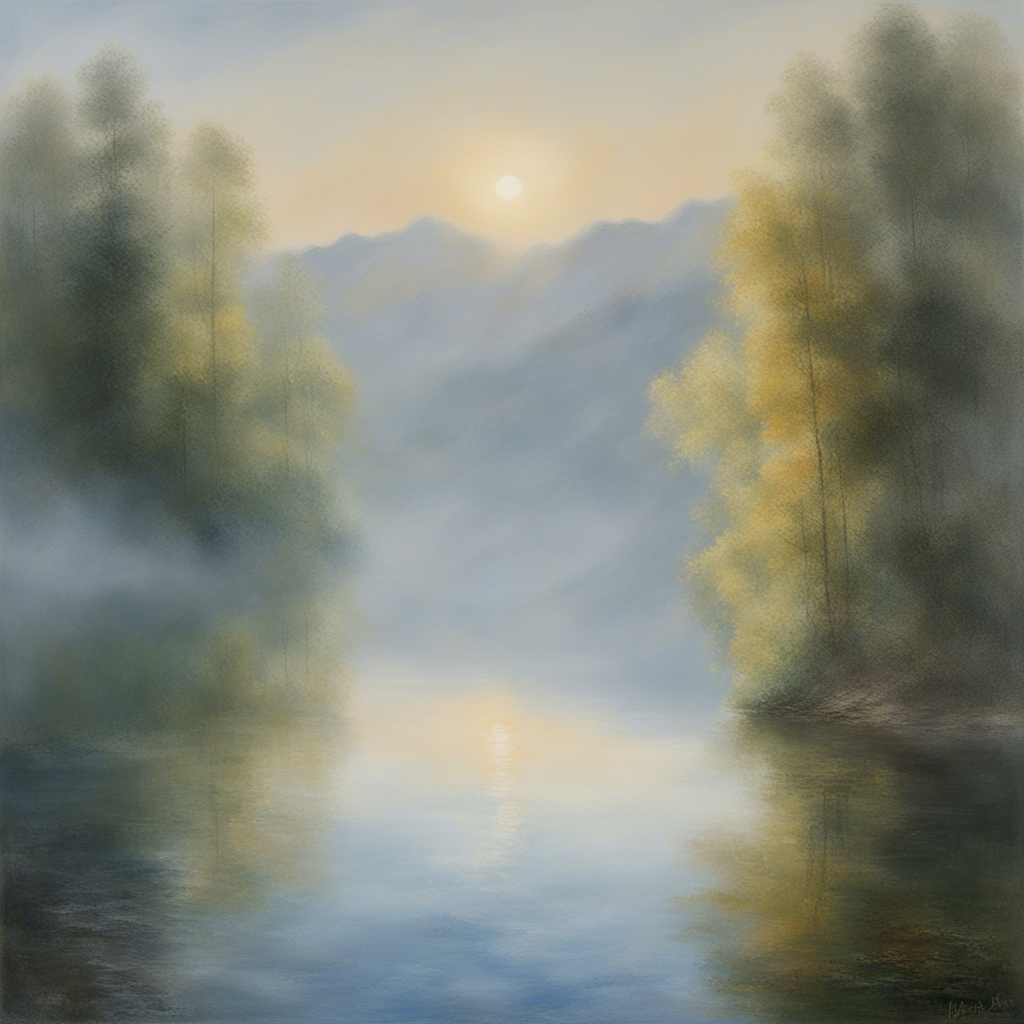

Done! Move to the next cell ->


In [56]:
# test the endpoint with some example payloads
import random

example_payloads = model.retrieve_all_examples()
#example_payloads = None # in case you want to force us of your own prompts

if example_payloads is None:
    print("Using your own as no example models available for this model.")
    # try your own payload
    if modelType == "llm":
        example_payloads = [
            {
                "body": {
                    "inputs": "Write a Python function to check if a number is prime",
                    "parameters": {
                        "max_new_tokens": 128,
                        "temperature": 0.2,
                        "top_p": 0.9,
                    },
                },
                "content_type": "application/json",
                "accept": "application/json",
            },
            {
                "body": {
                    "inputs": "Describe what a llm model can do for someone who is sceptical about them",
                    "parameters": {
                        "max_new_tokens": 128,
                        "temperature": 0.2,
                        "top_p": 0.9,
                    },
                },
                "content_type": "application/json",
                "accept": "application/json",
            },
        ]
    else:
        example_payloads = [
            {
                "text_prompts": [
                    {
                        "text": "A dramatic 1940s film noir scene in a rainy city alley, a detective in a trench coat and fedora under a flickering streetlamp, reflections on wet cobblestones, cinematic lighting, photorealistic, highly detailed, captured like a classic Hollywood movie still"
                    }
                ],
                "width": 1024,
                "height": 1024,
                "cfg_scale": 7.0,
                "steps": 150,
                "seed": random.randint(0, 4294967295),
            },
            {
                "text_prompts": [
                    {
                        "text": "A serene landscape of a misty mountain lake at dawn, soft sunlight filtering through the trees, reflections in the water, in the style of Claude Monet, impressionist painting, oil on canvas, highly detailed brushstrokes"
                    }
                ],
                "width": 1024,
                "height": 1024,
                "cfg_scale": 7.0,
                "steps": 150,
                "seed": random.randint(0, 4294967295),
            },
        ]

for payload in example_payloads:
    if modelType == "llm":
        body = payload.body if hasattr(payload, "body") else payload["body"]
        response = predictor.predict(body)
        response = response[0] if isinstance(response, list) else response
        print("Input:\n", body, end="\n\n")
        print("Output:\n", response["generated_text"].strip(), end="\n\n\n")
    else:
        #payload = json.dumps(payload).encode("utf-8") # in case you change the image model that needs it
        response = predictor.predict(payload)
        decode_and_show(response["generated_image"])

print("Done! Move to the next cell ->")

# <span style="color:DarkSeaGreen">Move to Lab 2</span>
# <span style="color:DarkSeaGreen">OR...</span>
# <span style="color:DarkSeaGreen">Clean Up Architecture</span>
### <span style="color:Red">Only do this if you have finished with this lab and any labs that depend on it!</span>
##### It will delete all architecture created, make sure you no longer need any of it!!!

In [46]:
# when finished with the endpoint, delete it
predictor.delete_predictor()
print ('Done! Move to the next cell ->')

Done! Move to the next cell ->


In [47]:
# delete roles and policies
iam.detach_role_policy(
    RoleName=myRoleSageMakerExecution, PolicyArn='arn:aws:iam::aws:policy/AmazonSageMakerFullAccess'
)
iam.delete_role(RoleName=myRoleSageMakerExecution)
print ('Done! Move to the next cell ->')

Done! Move to the next cell ->


In [48]:
# delete the parameter store entry
ssm.delete_parameter(Name=myParameterStoreChosenModel)
ssm.delete_parameter(Name=myParameterStoreEndpointName)
ssm.delete_parameter(Name=myParameterStoreIAMARN)
print ('Done! Move to the next cell ->')

Done! Move to the next cell ->


# <span style="color:DarkSeaGreen">Clean Up venv</span>
### Clean up if finished with this lab and running in VSCode or equivalent local IDE
#### Note these are macOS specific
- Run the commands of the cell below in a terminal window if you need to clean up a local venv
  - Note if you copy and paste the entire cell and run as one you will get zsh: command not found: # errors because of the comments, but you can ignore
  - Remember to restart the kernel to refresh whats available

In [ ]:
# if you have local host in your terminal prompt
unset HOST
# deactivate the venv
deactivate 
# remove it and its contents if not needed
rm -rf venv-jumpstart-lab1 